In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [13]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

In [2]:
# xr.open_dataset('/ocean/cdonaldson/research_runs/hindcast_auto/extractions/SalishSeaCast_river_trace_day_avg_allP_00_40_res1M_20200101_20201231.nc')

In [ ]:
# xr.open_dataset('/results/forcing/rivers/R202108Dailies_y2014m06d23.nc')

In [2]:
def grid_observations_by_time(
    obs_ds,
    grid_shape,
    time_freq="D",
    value_var="washwater",
    x_var="grid_x",
    y_var="grid_y",
    agg="sum",                      ## TODO: should this be sum or mean or what?
    dtype=np.float32,
):
    """
    Convert 1D observation dataset into 2D gridded fields by time bins.
    Output dims: (time, y, x)
    """

    ny, nx = grid_shape

    # Convert to DataFrame for fast grouping
    df = obs_ds[[value_var, x_var, y_var]].to_dataframe().reset_index()

    # Bin time
    df["time_bin"] = df["time"].dt.floor(time_freq)

    grids = []

    for t, g in df.groupby("time_bin"):
        grid = np.full((ny, nx), np.nan, dtype=dtype)

        cell = g.groupby([y_var, x_var])[value_var]

        if agg == "mean":
            cell = cell.mean()
        elif agg == "sum":
            cell = cell.sum()
        elif agg == "min":
            cell = cell.min()
        elif agg == "max":
            cell = cell.max()
        elif agg == "last":
            cell = cell.last()
        else:
            raise ValueError(f"Unknown aggregation: {agg}")

        y_idx = cell.index.get_level_values(0).to_numpy()
        x_idx = cell.index.get_level_values(1).to_numpy()
        vals = cell.to_numpy()

        grid[y_idx, x_idx] = vals

        da = xr.DataArray(
            grid,
            dims=("y", "x"),
            coords={
                "y": np.arange(ny),
                "x": np.arange(nx),
            },
            name=value_var,
        ).expand_dims(time=[t])

        grids.append(da)

    out = xr.concat(grids, dim="time")

    return out.to_dataset()

In [3]:
obs_ds = xr.open_dataset('/ocean/cdonaldson/scrubbers/yearly_obs/scrubber_1d_obs_20190101_20191231.nc')
obs_ds.head(10)

<xarray.Dataset>
Dimensions:    (time: 10)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01T00:09:27 ... 2019-01-01T00:32:37
Data variables:
    washwater  (time) float64 ...
    grid_x     (time) int64 ...
    grid_y     (time) int64 ...
    lat        (time) float64 ...
    lon        (time) float64 ...

In [4]:
ny, nx = 898, 398

In [5]:
daily_ds = grid_observations_by_time(
    obs_ds,
    grid_shape=(ny, nx),
    time_freq="D",
    agg="mean"
)

In [6]:
daily_ds

<xarray.Dataset>
Dimensions:    (time: 365, y: 898, x: 398)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2019-12-31
  * y          (y) int64 0 1 2 3 4 5 6 7 8 ... 890 891 892 893 894 895 896 897
  * x          (x) int64 0 1 2 3 4 5 6 7 8 ... 390 391 392 393 394 395 396 397
Data variables:
    washwater  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan

In [7]:
daily_ds = daily_ds.expand_dims(depth=[6.0])

In [8]:
for i in np.arange(len(daily_ds.time)):
    day_dat = daily_ds.isel(time=i)
    day_str = str(day_dat.time.values.astype('datetime64[D]')).replace('-', '')

    # save_loc = '/ocean/cdonaldson/scrubbers/daily_obs/'
    # day_dat.to_netcdf('{}scrubber_obs_freshcalc_{}.nc'.format(save_loc, day_str))

In [9]:
test_day = daily_ds.isel(time=200)

In [10]:
test_day

<xarray.Dataset>
Dimensions:    (depth: 1, y: 898, x: 398)
Coordinates:
  * depth      (depth) float64 6.0
    time       datetime64[ns] 2019-07-20
  * y          (y) int64 0 1 2 3 4 5 6 7 8 ... 890 891 892 893 894 895 896 897
  * x          (x) int64 0 1 2 3 4 5 6 7 8 ... 390 391 392 393 394 395 396 397
Data variables:
    washwater  (depth, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan

In [16]:
phys = xr.open_dataset('/results2/SalishSea/nowcast-green.201905/29sep22/SalishSea_1h_20220929_20220929_grid_T.nc')

In [20]:
phys.deptht[6]

<xarray.DataArray 'deptht' ()>
array(6.5003104, dtype=float32)
Coordinates:
    deptht   float32 6.5
Attributes:
    name:       deptht
    long_name:  Vertical T levels
    units:      m
    positive:   down
    bounds:     deptht_bounds

In [ ]:
test_day.time

<xarray.DataArray 'time' ()>
array('2019-07-20T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2019-07-20

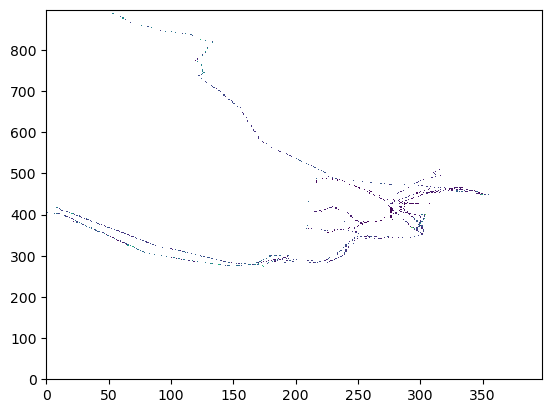

In [ ]:
plt.pcolormesh(test_day.isel(depth=0)['washwater'].values)

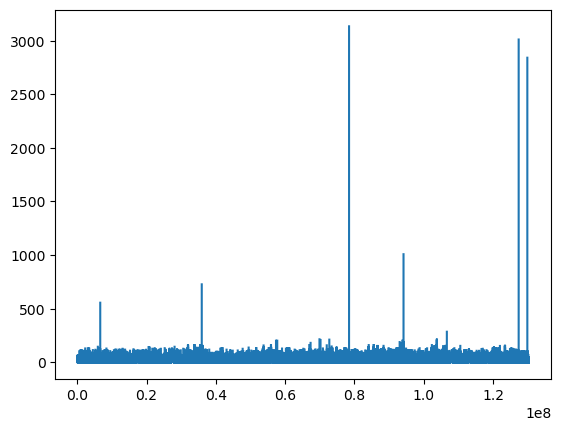

In [ ]:
plt.plot(daily_ds.washwater.values.flatten())